In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
import re

In [2]:
import komma_dev.eu
from komma_dev.vocabulary import build_vocabulary
from komma_dev.parsing import StringParser

# Analysis of the EU corpus

## Loading the data

In [3]:
eu_data_raw = komma_dev.eu.load('da')

loading: europarl-v7.da-en.da


In [4]:
eu_data_raw = [line.strip() for line in eu_data_raw]

In [5]:
parser = StringParser()
eu_data = [parser.parse(line) for line in eu_data_raw]

In [6]:
len(eu_data)

1968800

In [7]:
eu_data[1].text

'Jeg erklærer Europa-Parlamentets session, der blev afbrudt fredag den 17. december, for genoptaget. Endnu en gang vil jeg ønske Dem godt nytår, og jeg håber, De har haft en god ferie.'

## Distribution of words in the sentences

In [221]:
sen_len = [len(sentence.features) for sentence in eu_data]

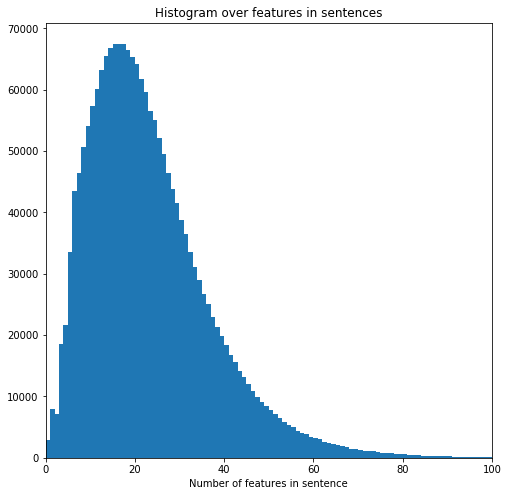

In [222]:
fix, ax = plt.subplots(figsize=(8,8))
ax.hist(sen_len, bins=np.arange(0,200));
ax.set_xlim([0, 100])
ax.set(xlabel='Number of features in sentence', title='Histogram over features in sentences');

Using a sentence length of 100 words will get the vast majority of words. Using 50 as we do now still leaves out quite a chunk of sentences.

In [223]:
np.sum(np.array(sen_len)>50)/np.sum(np.array(sen_len)>0)*100

4.2881704240253926

So 4% of the sentences include more than 50 tokens.

## Analysing the vocabulary

In [11]:
cleaned_sentences = [re.sub("\s,", ',', sentence.text) for sentence in eu_data]

In [13]:
corpus = ' '.join(cleaned_sentences)
count = Counter(corpus.split())
len(count)

645152

With the current dataset it should not be necessary to increase vocabulary size above 650k if we wish to map all tokens to unique integers.

In [131]:
cleaned_sentences = [' '.join([chunk.feature for chunk in sentence.chunks]) for sentence in eu_data]

In [132]:
corpus = ' '.join(cleaned_sentences)
count = Counter(corpus.split())
len(count)

424056

In [133]:
freq = [count.get(item) for item in count]
words = [item for item in count]

In [134]:
freq_limits = np.arange(1,250, 1)
words_more_frequent = [len(np.where(np.array(freq)>=limit)[0]) for limit in freq_limits]

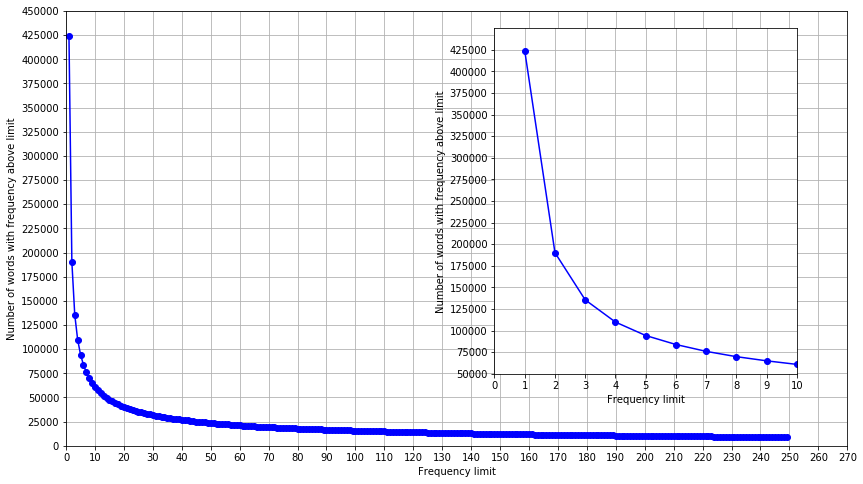

In [137]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(freq_limits, words_more_frequent, 'o-b')
ax.set(xlabel='Frequency limit', ylabel='Number of words with frequency above limit');
ax.set_ylim([0, 450000])
ax.set_xlim([0, 250])
ax.set_xticks(np.arange(0,280,10))
ax.set_yticks(np.arange(0,455000, 25000))
ax.grid()

left, bottom, width, height = [0.55, 0.25, 0.3, 0.6]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(freq_limits, words_more_frequent, 'o-b')
ax2.set_xlim([1, 10])
ax2.set_ylim([50000, 450000])
ax2.set_xticks(np.arange(0,11,1))
ax2.set_yticks(np.arange(50000,450000, 25000))
ax2.set(xlabel='Frequency limit', ylabel='Number of words with frequency above limit')
ax2.grid();

## Making all words lower case

In [138]:
lower = [' '.join([chunk.feature.lower() for chunk in sentence.chunks]) for sentence in eu_data]

In [139]:
lower_corpus = ' '.join(lower)
lower_count = Counter(lower_corpus.split())
len(lower_count)

393341

so about 4k of the words are different simply because of capitalization.

## Looking at information loss as a function of sentence length
When we restrict the vocabulary size, we end up mapping a lot of words to the same number. This reduces the information in the sentences. Here I investigate how many sentences retain all information as a function of vocabulary size. 

In [159]:
MAX_CHUNKS = 50
def embed_sentence(sentence, vocabulary):
    embedded = [0] * MAX_CHUNKS
    for index, chunk in enumerate(sentence.chunks[:MAX_CHUNKS]):
        word = chunk.clean_name
        if word in vocabulary:
            continue
        else:
            embedded[index] = 1
    return embedded

In [185]:
loss_counts = []
unknowns_in_sentences = []
vocab_lens = np.append(np.arange(10000, 110000, 10000 ), np.arange(200000, 500000, 100000))
for vocab_len in vocab_lens:
    vocab, _ = build_vocabulary(eu_data, vocab_len)
    loss_count = 0
    unknown_in_sen_count = []
    for sentence in eu_data:
        unknown_words_in_sen = np.sum(embed_sentence(sentence, vocab))
        unknown_in_sen_count.append(unknown_words_in_sen)
        if unknown_words_in_sen>0:
            loss_count += 1
    unknowns_in_sentences.append(unknown_in_sen_count)
    sentence_loss = loss_count/len(eu_data)
    loss_counts.append(sentence_loss)

In [216]:
fewer_than_3_unknows = [np.sum(np.array(unknowns)<3)/len(eu_data) for unknowns in unknowns_in_sentences] 
fewer_than_2_unknows = [np.sum(np.array(unknowns)<2)/len(eu_data) for unknowns in unknowns_in_sentences]
fewer_than_1_unknows = [np.sum(np.array(unknowns)<1)/len(eu_data) for unknowns in unknowns_in_sentences]

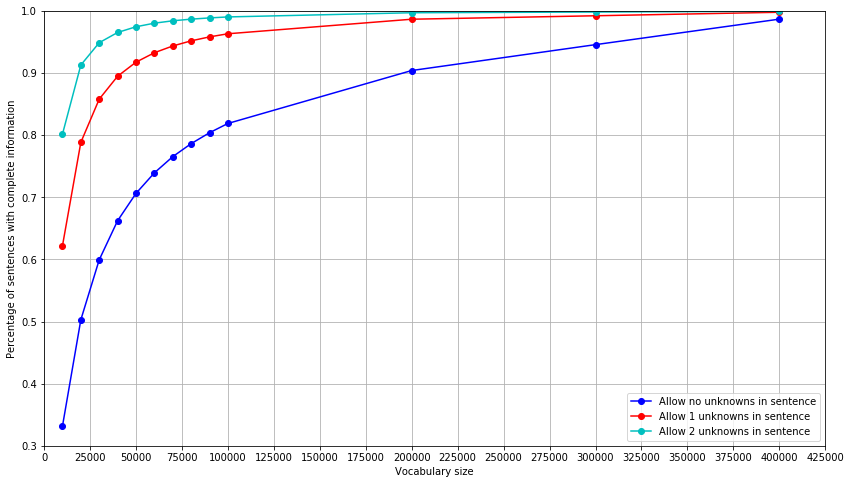

In [219]:
fig, ax = plt.subplots(figsize=(14,8))
ax.plot(vocab_lens, np.array(fewer_than_1_unknows), 'o-b', label='Allow no unknowns in sentence')
ax.plot(vocab_lens, np.array(fewer_than_2_unknows), 'o-r', label='Allow 1 unknowns in sentence')
ax.plot(vocab_lens, np.array(fewer_than_3_unknows), 'o-c', label='Allow 2 unknowns in sentence')
ax.set(xlabel='Vocabulary size', ylabel='Percentage of sentences with complete information');
ax.set_ylim([0.3, 1])
ax.set_xlim([0, 400000])
ax.set_xticks(np.arange(0, 450000, 25000))
ax.set_yticks(np.arange(0.3 ,1.1, 0.1))
ax.grid()
ax.legend();